### Task 10: Add Constant Product Trading interest rate as continuous rebase
* https://cryptorating.eu/whitepapers/Aave/aave-v2-whitepaper.pdf

In [10]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
cwd =  os.getcwd().replace("notebooks/test","")
os.chdir(cwd)

from python.dev.event.state.series import StateSeries
from python.dev.event.state import State
from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.token.trade import Convert
from python.dev.cpt import Liquidity
from python.dev.cpt import PriceCurve
from python.dev.cpt import ConstantProductTrade
from python.dev.plot import PlotPriceCurve
from python.dev.token import RebaseToken
from python.dev.math.model import TimeDeltaModel
from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import EventSelectionModel

In [11]:
time0 = time.time()

In [12]:
APY = 0.1
state = State(Deposit(0,0,0))
state.init_first_state(time0)
state_series = StateSeries()

for k in range(320):
    delta = TokenDeltaModel(1,10).apply()  
    select = EventSelectionModel().bi_select(0.7)
    t_delta = TimeDeltaModel().apply()
      
    if(select == EventSelectionModel().FIRST): 
        event = Deposit(APY,delta,t_delta)
    else:
        event = Withdraw(APY,delta,t_delta)  

    state.update_event(event)
    state_series.add_state(state)
    

principle = state_series.get_principle() 
balance = state_series.get_balance() 
tSamp = state_series.get_tstamp()

In [13]:
for k in range(10):
    type_event = state_series.get_state(k).get_event().type_of()
    print('{}: {} @ {}'.format(k, type_event, tSamp[k]))

0: DEPOSIT @ 2022-05-19 12:16:48.274937
1: DEPOSIT @ 2022-05-20 02:58:18.274937
2: DEPOSIT @ 2022-05-20 22:20:37.274937
3: DEPOSIT @ 2022-05-21 10:50:06.274937
4: WITHDRAW @ 2022-05-23 04:58:44.274937
5: WITHDRAW @ 2022-05-27 04:16:36.274937
6: WITHDRAW @ 2022-05-28 00:34:58.274937
7: DEPOSIT @ 2022-05-28 16:36:48.274937
8: DEPOSIT @ 2022-05-29 04:41:38.274937
9: DEPOSIT @ 2022-05-29 12:47:42.274937


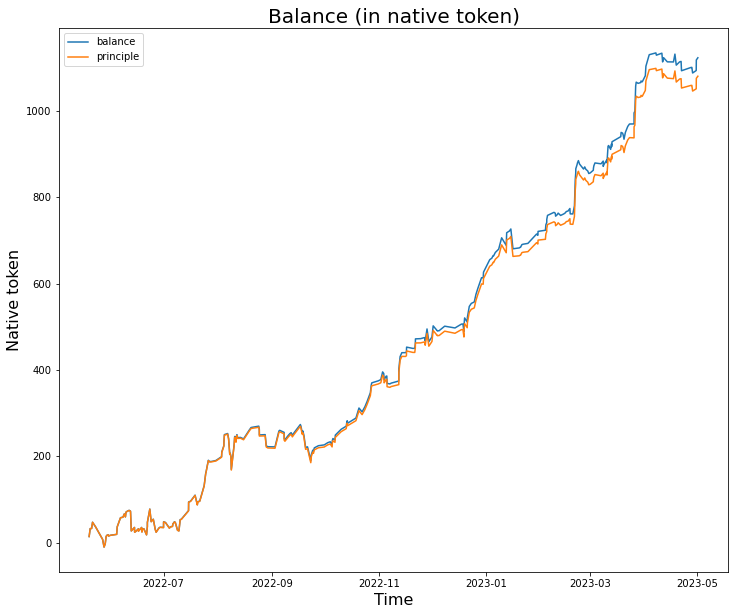

In [14]:
import matplotlib.pyplot as plt

fig, (balance_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(12, 10))

balance_ax.plot(tSamp, balance, label='balance') 
balance_ax.plot(tSamp, principle, label='principle') 

balance_ax.set_title("Balance (in native token)", fontsize=20)
balance_ax.set_ylabel("Native token", fontsize=16)
balance_ax.set_xlabel('Time', fontsize=16)
balance_ax.legend()


In [15]:
# Initialize Test Tokens

TYPE_DEPOSIT_TOKEN = 'DEPOSIT'
TYPE_DEBT_TOKEN = 'DEBT'

t_delta = TimeDeltaModel().apply()
depositT1 = TokenDeltaModel(2,20000).apply() 

T1 = RebaseToken(TYPE_DEPOSIT_TOKEN)
t1Address = T1.mint(depositT1, APY)


t_delta = TimeDeltaModel().apply()
depositTDT = TokenDeltaModel(2,20000).apply() 

TDT = RebaseToken(TYPE_DEBT_TOKEN)
tdtAddress = TDT.mint(depositT1, APY)

x = T1.get_balance_deposits()
y = TDT.get_balance_deposits()

print('[Initial] T1: {:.2f} TDT: {:.2f}\n'.format(x,y))

[Initial] T1: 7882.84 TDT: 7882.84



In [16]:
# Initialize Liquidity Pool
liq = Liquidity(x,y)
L = liq.calc(); #p = np.random.normal(5,0.1,1)[0]
p = liq.get_swap_price()
cpt = ConstantProductTrade(L)
pCurve = PriceCurve(L)

[Trade 0] T1: 7721.14205 TDT: 8047.90883 L: 7884.52544
[Trade 0] T1_prin: 7719.45242 T1_balance: 7721.14205
[Trade 0] TDT_prin: 8046.21920 TDT_balance: 8047.90883

[Trade 50] T1: 7662.09644 TDT: 8350.67726 L: 8006.80219
[Trade 50] T1_prin: 7540.19439 T1_balance: 7662.09644
[Trade 50] TDT_prin: 8225.47723 TDT_balance: 8350.67726

[Trade 100] T1: 7756.86956 TDT: 8488.62243 L: 8124.07597
[Trade 100] T1_prin: 7526.67635 T1_balance: 7756.86956
[Trade 100] TDT_prin: 8238.99528 TDT_balance: 8488.62243

[Trade 150] T1: 9188.24361 TDT: 7248.19892 L: 8220.56301
[Trade 150] T1_prin: 8858.04057 T1_balance: 9188.24361
[Trade 150] TDT_prin: 6907.63106 TDT_balance: 7248.19892

[Trade 200] T1: 10665.20333 TDT: 6044.81497 L: 8367.86975
[Trade 200] T1_prin: 10170.26572 T1_balance: 10665.20333
[Trade 200] TDT_prin: 5595.40591 TDT_balance: 6044.81497



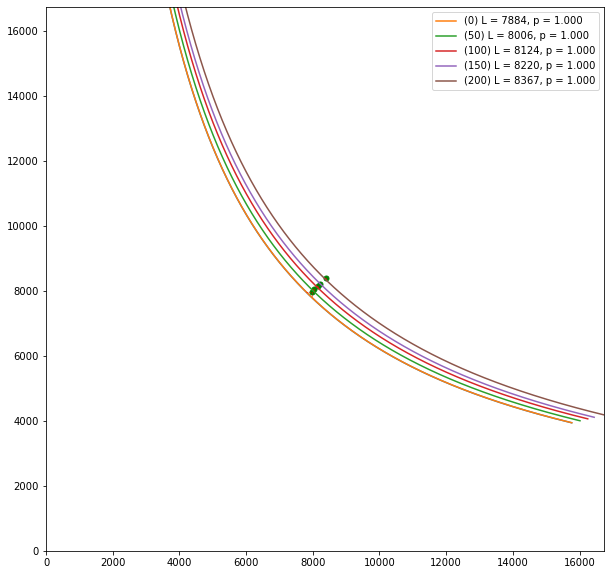

In [17]:
# Plot and execute N trades
percent = 0.05
N = 250

plotCurve = PlotPriceCurve(L, cpt, pCurve)
plotCurve.apply(p, None)

for k in range(N):
    # Generate random delta denomenated in Native token, 
    # rebalance respective accounts and convert to T1
    delta_x = TokenDeltaModel(1,100).apply() 
    t_delta = TimeDeltaModel().apply()

    select = EventSelectionModel().bi_select(0.5)
    if(select == EventSelectionModel().FIRST): 
        T1.add_event(Withdraw(APY, delta_x, t_delta, t1Address))
        TDT.add_event(Deposit(APY, delta_x, t_delta, tdtAddress)) 
    else:            
        T1.add_event(Deposit(APY, delta_x, t_delta, t1Address))
        TDT.add_event(Withdraw(APY, delta_x, t_delta, tdtAddress))
        delta_x = -delta_x
    
    TDT_yield = TDT.get_state_series(tdtAddress).get_state(k).get_yield()
    T1_yield = T1.get_state_series(t1Address).get_state(k).get_yield()
    
    liq.delta_y(TDT_yield)
    liq.delta_x(T1_yield) 
    
    x = T1.get_balance_deposits()
    y = TDT.get_balance_deposits()    
    
    L = liq.swap(delta_x); # p = np.random.normal(5,0.1,1)[0]
    p = liq.get_swap_price()
    if (k % int(N/(100*percent)) == 0):
        plotCurve.apply_next(p, L, '({}) L = {}, p = {:.3f}'.format(k, int(L),p))
        plotCurve.plot_trade(p, delta_x, 'r--')
        T1_prin = T1.get_state_series(t1Address).get_state(k).get_principle()
        T1_balance = T1.get_state_series(t1Address).get_state(k).get_balance()

        TDT_prin = TDT.get_state_series(tdtAddress).get_state(k).get_principle()
        TDT_balance = TDT.get_state_series(tdtAddress).get_state(k).get_balance()
            
        print('[Trade {}] T1: {:.5f} TDT: {:.5f} L: {:.5f}'.format(k, x,y,L))
        print('[Trade {}] T1_prin: {:.5f} T1_balance: {:.5f}'.format(k, T1_prin,T1_balance))
        print('[Trade {}] TDT_prin: {:.5f} TDT_balance: {:.5f}\n'.format(k, TDT_prin,TDT_balance))
      




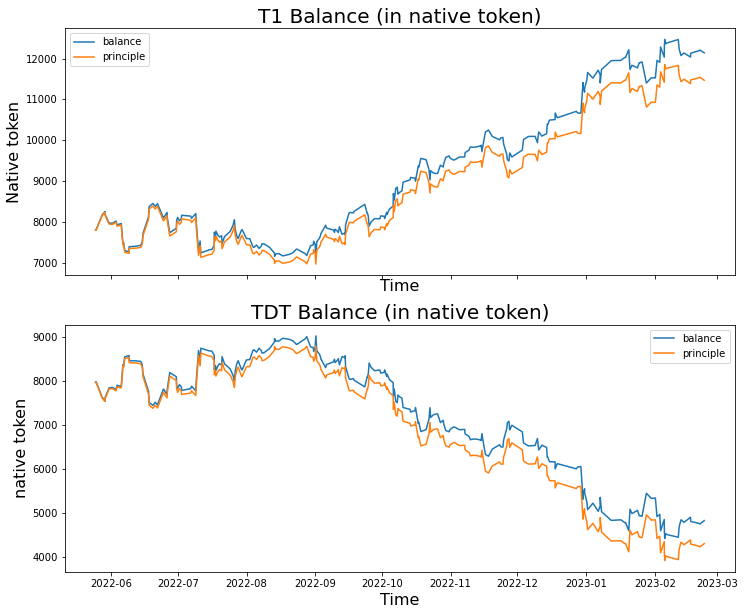

In [18]:
# Analyze Token balances

T1_states = T1.get_state_series(t1Address)
principle = T1_states.get_principle() 
balance = T1_states.get_balance() 
tSamp = T1_states.get_tstamp()  

fig, (T1_ax, TDT_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

T1_ax.plot(tSamp[1:], balance[1:], label='balance') 
T1_ax.plot(tSamp[1:], principle[1:], label='principle') 
T1_ax.set_title("T1 Balance (in native token)", fontsize=20)
T1_ax.set_ylabel("Native token", fontsize=16)
T1_ax.set_xlabel('Time', fontsize=16)
T1_ax.legend()

TDT_states = TDT.get_state_series(tdtAddress)
principle = TDT_states.get_principle() 
balance = TDT_states.get_balance() 
tSamp = TDT_states.get_tstamp() 

TDT_ax.plot(tSamp[1:], balance[1:], label='balance') 
TDT_ax.plot(tSamp[1:], principle[1:], label='principle') 
TDT_ax.set_title("TDT Balance (in native token)", fontsize=20)
TDT_ax.set_ylabel("native token", fontsize=16)
TDT_ax.set_xlabel('Time', fontsize=16)
TDT_ax.legend()
